In [1]:
import RAP_MASTER_LIB
#MY LIBRARIES -- towards the end of project/when you need a break write up documentaiton of libraries
#another library for plotting and testing
from rap_scrpr import *
from rap_db import *
from rap_clean import*
import matplotlib.pyplot as plt
from statistics import mean, median 
estconn = pg2.connect(database='rap_songs', user='keenan', host='localhost', password='keenan')
#create_music_tables(estconn)

import RAP_MASTER_LIB
import re
from bs4 import BeautifulSoup
import urllib
import time
import json
import psycopg2 as pg2
import psycopg2.extras

from rap_scrpr import *
from rap_db import *
from rap_clean import*
#nltk.download()
from os import listdir
from os.path import isfile, join

estconn = pg2.connect(database='rap_songs', user='keenan', host='localhost', password='keenan')
#create_music_tables(estconn)

In [2]:
#scrape artist
#create_music_tables(estconn, bypass = True)
#new_artists = scrape_multi_artists(estconn, ['10sion'])
#load them into db
#bulk_load(estconn, new_artists)
#create the artist, album, song, and verse objects
#works = construct_artists(estconn, art_list = ['Del','Chance the Rapper','MF Doom','50 Cent'], use_ind_artists=False)

In [3]:
works = construct_artists(estconn, art_list = ['MF Doom'], use_ind_artists=False)

what you did
implemented construct artists on the backend
you enter artist, albums, songs and it filters any matchces it finds of that

next is viz and modeling forsure

CHANGING BACK END TO REMOVE SOUND EFFECTS LIKE (),{},**,ETC. IMPT, LEFT COMMENT AT LINE 197

In [4]:
#this is sick

MF Doom


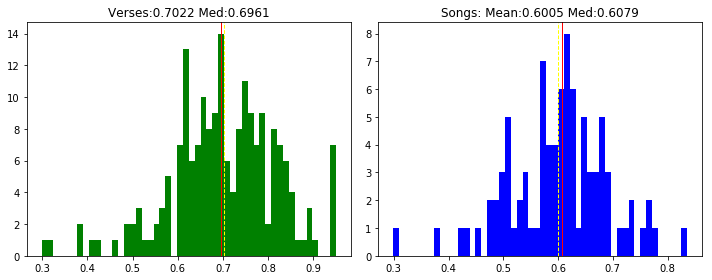

In [5]:
def quick_plot(artist_obj_list, b = 50):
    #good start, build on ideas from here
    #this is too messy for your final shit
    for art in artist_obj_list:
        #by verse
        uniq_vs = []
        for v in art.verses:
            uniq_vs.append(len(v.unique_words)/len(v.all_words))
        #by song
        uniq_ss = []
        for s in art.songs:
            one_song = set()
            one_song_all = []
            for seg in s.segments:
                if type(seg) == verse:
                    one_song = one_song|seg.unique_words
                    one_song_all.extend(seg.all_words)
            if one_song and one_song_all:
                uniq_ss.append(len(one_song)/len(one_song_all))
        print(art.name)
        
        #graphs
        rnd = 4
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
        ax1.hist(uniq_vs, bins=b, color='green')
        ax1.axvline(mean(uniq_vs), color='yellow', linestyle='dashed', linewidth=1)
        ax1.axvline(median(uniq_vs), color='red', linestyle='solid', linewidth=1)
        ax1.set_title('Verses:'+str(round(mean(uniq_vs),rnd))+' Med:'+str(round(median(uniq_vs),rnd)))
        ax2.hist(uniq_ss, bins=b, color='blue')
        ax2.axvline(mean(uniq_ss), color='yellow', linestyle='dashed', linewidth=1)
        ax2.axvline(median(uniq_ss), color='red', linestyle='solid', linewidth=1)
        fig.tight_layout()
        ax2.set_title('Songs: Mean:'+str(round(mean(uniq_ss),rnd))+' Med:'+str(round(median(uniq_ss),rnd)))
        plt.show()
        #quick insight, leaving in [], {}, "", () lowered chances avg
quick_plot(works)

In [8]:
all_verses = []
for v in works[0].verses:
    all_verses.append((len(v.unique_words)/len(v.all_words), v.content, v.unique_words))
all_verses = sorted(all_verses, reverse=True)

for a in all_verses[:5]:
    print(a[0], a[1])
    print()

0.95 
looking at his henny sip
look at little pretty chicks
sucka's tryin to penny flip
niggaz looping any shit



0.9473684210526315 
run up in your fucking lab looking for goodies
a hundred tooties decked out in fatass robes and st vitus hoodies
three man team screaming for vengeance
i shed repentence until my last sentence
time to end this

0.9444444444444444 
on the strength, she wasn't lent three cent
got her own connect for free rent off the cement
now what if that was your moms short arms 
quarter waters to bottles of dom bought the {}



0.9444444444444444 
just as the mask, some people wear a mask
don't mean that they did something {*more laughter*}

0.9375 
no doubt 
krazy world, get it where you fit in...
....

"attention: we have heard from the control center on monster island that the 
two monsters have broken out. all men stand by!"



what you did

literally two hours tix an insanneee verse bug
but, increased accuracy of unique words by a lot
revamped remove and reass method to be way more accurate/usable

what's next
make meta data calcs and graphing backend
possibly add that stuff to db (maybe)

In [7]:
#estconn.close()